In [1]:
using Pkg

Pkg.activate("/home/rs/.julia/environments/triangulations/")

"/home/rs/.julia/environments/triangulations/Project.toml"

In [67]:
using Random
Random.seed!(1);

# CairoMakie plotting basics

In [49]:
using AbstractPlotting
using CairoMakie

In [68]:
n = 7

x = 400 * rand(n)
y = 200 * rand(n)
[x y]'

2×7 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
  94.4133  138.607   125.083    3.16371  195.445   84.3873  380.767
 199.981    50.3324  197.333  111.15      87.4216  84.9436  154.645

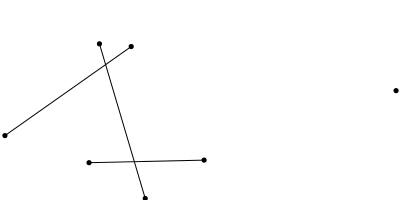

In [69]:
scene = Scene(resolution=(400,200), show_axis=false, scale_plot=false)
scatter!(x, y, markersize=5)
linesegments!(x, y)

In [70]:
make_scene() = Scene(resolution=(400,200), show_axis=false, scale_plot=false)

make_scene (generic function with 1 method)

# TriangleMesh.jl

In [72]:
using TriangleMesh

In [128]:
# simple point cloud meshing
p = [x y]
mesh = create_mesh(p);

┌ Info: Number of point markers > 1. Only 0 or 1 admissible. Set to 1.
└ @ TriangleMesh /home/rs/.julia/packages/TriangleMesh/1MqBd/src/TriangleMesh_Polygon.jl:43


In [129]:
mesh.point

2×25 Array{Float64,2}:
  94.4133  138.607   125.083    3.16371  …  156.036   106.097  254.514
 199.981    50.3324  197.333  111.15         87.7155  156.365  175.724

In [130]:
mesh.edge

2×58 Array{Int64,2}:
  8  16  4  11  13  23  24  16  22  8  …  25   9   2  22  21  19  24  9   7
 16   4  8  13  23  11  16  22  24  6     20  25  11  21  19  22  19  7  25

In [131]:
mesh.segment

2×14 Array{Int64,2}:
  2  7   3  1  4  8   9  10  11  12  14  15  17  25
 15  9  25  3  1  4  12  11   2  14  10  17   8   7

In [132]:
edge_array = mesh.point[:, vec(mesh.edge)]

2×116 Array{Float64,2}:
 70.8853   66.316   66.316    3.16371  …  259.687  380.767  380.767  254.514
 80.7413  119.215  119.215  111.15        102.489  154.645  154.645  175.724

In [164]:
"Draw mesh based on initial points."
function draw_mesh(mesh, points)
    scene = make_scene()
    linesegments!(mesh.point[:, vec(mesh.edge)]', color=:gray, linestyle=:dot)
    linesegments!(mesh.point[:, vec(mesh.segment)]')
    scatter!(points, markersize=8, color=:red)
    scatter!(mesh.point', markersize=4)
end

draw_mesh

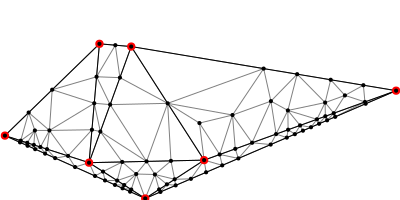

In [165]:
draw_mesh(mesh, p)

┌ Info: Number of point markers > 1. Only 0 or 1 admissible. Set to 1.
└ @ TriangleMesh /home/rs/.julia/packages/TriangleMesh/1MqBd/src/TriangleMesh_Polygon.jl:43


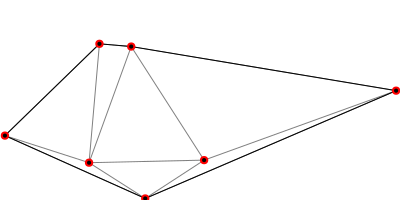

In [166]:
# again, but no Steiner points
mesh = create_mesh(p, prevent_steiner_points=true, delaunay=true)
draw_mesh(mesh, p)

In [135]:
mesh1 = mesh;

In [137]:
mesh1.segment

2×5 Array{Int64,2}:
 2  7  3  1  4
 4  2  7  3  1

In [139]:
mesh1.edge

2×13 Array{Int64,2}:
 4  6  1  4  2  6  3  5  6  5  2  7  7
 6  1  4  2  6  3  1  3  5  2  7  5  3

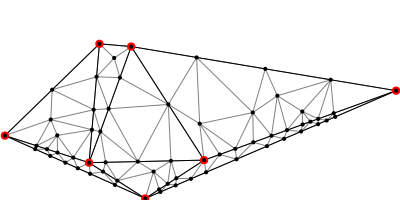

In [167]:
# refine this mesh
mesh = refine(mesh1, keep_edges=true)
draw_mesh(mesh, p)

┌ Info: Neither segments nor edges will be kept during the refinedment.
└ @ TriangleMesh /home/rs/.julia/packages/TriangleMesh/1MqBd/src/TriangleMesh_refine.jl:150


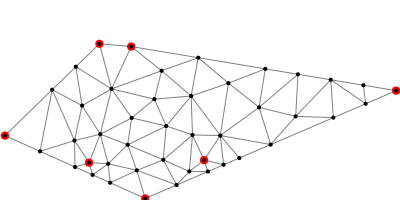

In [168]:
# refine this mesh
mesh = refine(mesh1)
draw_mesh(mesh, p)

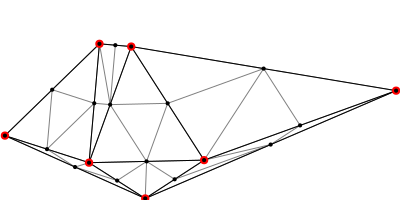

In [169]:
# refine this mesh
mesh = refine_rg(mesh1)
draw_mesh(mesh, p)

In [143]:
# easy to understand and repeatable, but still awkward Steiner points?
mesh2 = mesh;

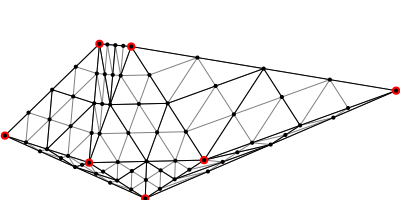

In [170]:
# refine this mesh, again
mesh = refine_rg(mesh2)
draw_mesh(mesh, p)

In [94]:
# looks too regular :-\ try again

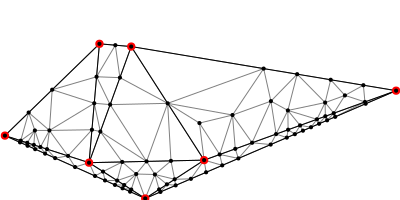

In [171]:
# refine this mesh, again
mesh = refine(mesh2, divide_cell_into=1, keep_segments=true)
draw_mesh(mesh, p)

In [157]:
# just using pre-existing meshing methods and refinements is not good enough :-(

In [149]:
mesh1.edge

2×13 Array{Int64,2}:
 4  6  1  4  2  6  3  5  6  5  2  7  7
 6  1  4  2  6  3  1  3  5  2  7  5  3

In [156]:
size(points, 1)

2

In [172]:
function polygon_from_mesh(mesh)
    points = mesh1.point
    segments = mesh1.edge

    poly = Polygon_pslg(size(points, 2), 0, 0, size(segments, 2), 0)
    set_polygon_point!(poly, points')
    set_polygon_segment!(poly, segments')

    return poly
end

polygon_from_mesh (generic function with 1 method)

In [173]:
poly1 = polygon_from_mesh(mesh1)

Polygon_pslg(7, [94.4133 138.607 … 84.3873 380.767; 199.981 50.3324 … 84.9436 154.645], 0, Array{Int32}(0,7), 0, Array{Float64}(0,7), 13, Int32[4 6 … 7 7; 6 1 … 5 3], Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 0, Array{Float64}(2,0))

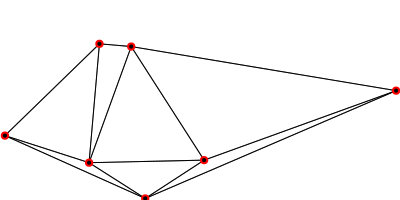

In [188]:
mesh1 = create_mesh(poly1, add_switches="S0")
draw_mesh(mesh1, p)

In [201]:
function add_points(mesh, points)
    points = hcat(mesh.point, points)
    segments = mesh.segment

    poly = Polygon_pslg(size(points, 2), 0, 0, size(segments, 2), 0)
    set_polygon_point!(poly, points')
    set_polygon_segment!(poly, segments')

    # no extra Steiner points
    return create_mesh(poly, add_switches="S0")
end

add_points (generic function with 1 method)

In [209]:
mesh1.point

2×7 Array{Float64,2}:
  94.4133  138.607   125.083    3.16371  195.445   84.3873  380.767
 199.981    50.3324  197.333  111.15      87.4216  84.9436  154.645

In [207]:
mesh1.cell

3×7 Array{Int64,2}:
 4  6  1  5  5  7  5
 6  4  6  3  2  3  6
 1  2  3  6  7  5  2

In [222]:
triangle_centers(mesh) = mean(mesh.point[:, mesh.cell], dims=2)[:,1,:]

triangle_centers (generic function with 1 method)

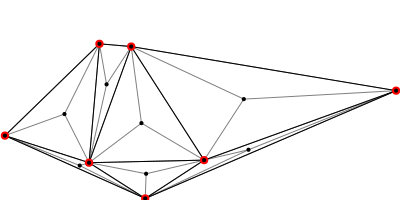

In [223]:
mesh2 = add_points(mesh1, triangle_centers(mesh1))
draw_mesh(mesh2, p)

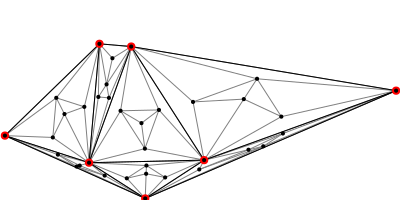

In [224]:
mesh3 = add_points(mesh2, triangle_centers(mesh2))
draw_mesh(mesh3, p)

# Triangle.jl

In [22]:
using Triangle

triangles = Array{Int64,1}[[4, 3, 2], [3, 4, 1], [2, 3, 6], [1, 5, 6], [7, 2, 6], [7, 6, 5], [6, 3, 1]]
edges = [4 3 2 3 4 1 2 3 6 1 5 6 7 2 6 7 6 5 6 3 1; 3 2 4 4 1 3 3 6 2 5 6 1 2 6 7 6 5 7 3 1 6]


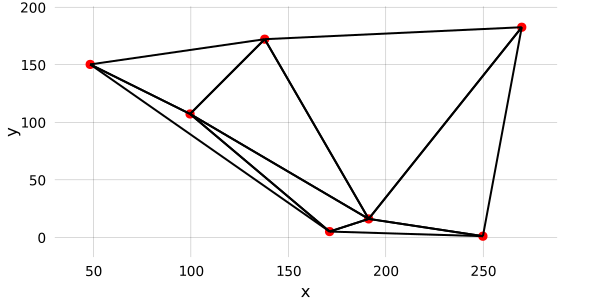

In [23]:
# Start with straight-forward Delaunay triangulation, again.
points = [x y]
points_map = collect(1:n)

triangles = basic_triangulation(points, points_map)
@show triangles

edges = reshape(vcat([t[[1, 2, 2, 3, 3, 1]] for t in triangles]...), 2, :)
@show edges

scene = Scene(resolution=(600,300))
scatter!(x, y, markersize=8, color=:red)
linesegments!(points[vec(edges), :], linewidth=2)

In [26]:
using Statistics

In [27]:
mean([1 2; 3 4], dims=1)

1×2 Array{Float64,2}:
 2.0  3.0

In [28]:
# for each triangle, add a point in the center (mean)
centers = [mean(points[t, :], dims=1) for t in triangles]

7-element Array{Array{Float64,2},1}:
 [95.2721 143.261]
 [106.362 87.5334]
 [142.895 98.5067]
 [204.069 7.36813]
 [199.623 123.625]
 [236.937 66.5553]
 [153.985 42.7793]

centers_array = [95.2721 143.261; 106.362 87.5334; 142.895 98.5067; 204.069 7.36813; 199.623 123.625; 236.937 66.5553; 153.985 42.7793]


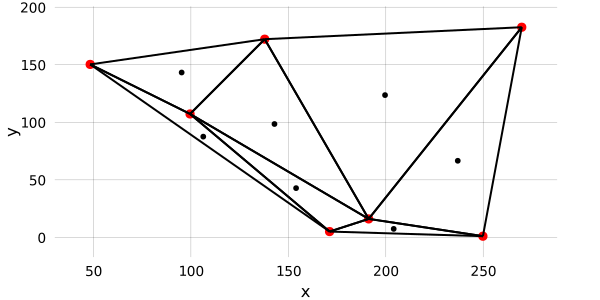

In [33]:
centers_array = reshape(hcat(centers...), 2, :)'
@show centers_array
scatter!(centers_array, markersize=5)

In [29]:
edges'[:,:]

21×2 Array{Int64,2}:
 4  3
 3  2
 2  4
 3  4
 4  1
 1  3
 2  3
 3  6
 6  2
 1  5
 5  6
 6  1
 7  2
 2  6
 6  7
 7  6
 6  5
 5  7
 6  3
 3  1
 1  6

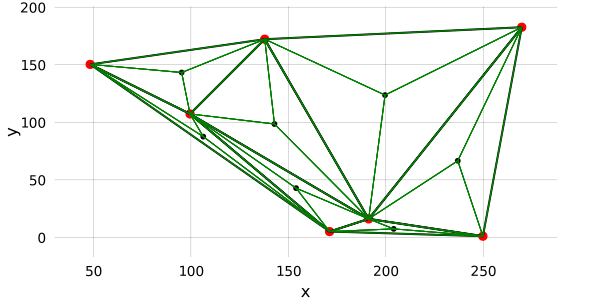

In [35]:
points2 = vcat(points, centers_array)
points_map2 = collect(1:size(points2, 1))
triangles2 = constrained_triangulation(points2, points_map2, edges'[:,:])

edges2 = reshape(vcat([t[[1, 2, 2, 3, 3, 1]] for t in triangles2]...), 2, :)
linesegments!(points2[vec(edges2), :], color=:green)

In [30]:
# need also subdivide the edges that we want to keep?
# TODO...